In [1]:
import pandas as pd
base_dir = 'data/McGill-Billboard'
data_index = 'billboard-2.0-manychords.csv'

df_songs = pd.read_csv(f'{base_dir}/{data_index}')
#df_songs = pd.read_csv(f'{data_index}') # colab
df_songs.set_index('id', inplace=True)
len(df_songs)

719

In [2]:
df_songs.head(n=3)

,title,artist,no_chord_percent
id,,,
3,I Don't Mind,James Brown,0.049747
4,You've Got A Friend,"Roberta Flack,Donny Hathaway",0.050770
6,The Rose,Bette Midler,0.117244


In [3]:
test_ids = [1289, 736, 637, 270, 18] # songs to exclude for testing
df_dataset = df_songs.drop(index=test_ids)
len(df_dataset)

714

#### Splitting

In [4]:
import numpy as np
_SEED = 0

df_idxs = np.array(df_dataset.index.values)
rng = np.random.default_rng(_SEED)
rng.shuffle(df_idxs)

df_idxs[:10]

array([1167,    6,  986,  227,  743,  568,  107,  181,   27,  793])

In [5]:
from dataloader import ChromaSequenceDataset
# import dataloader
# from importlib import reload
# reload(dataloader)

_LABEL_TYPE = 'majmin'
_SEQ_LEN = 128

pre_computed_seq = f'data/chordseq/{_LABEL_TYPE}_{_SEQ_LEN}.pkl'
#pre_computed_seq = f'{_LABEL_TYPE}_{_SEQ_LEN}.pkl' # colab
ds = ChromaSequenceDataset(pre_computed_sequence=pre_computed_seq)

Loaded sequence data.


In [6]:
for train_split, val_split in ds.get_next_cv_split(df_idxs):
    print(train_split.shape, val_split.shape)

((21936, 128, 24), (21936, 128)) ((3470, 128, 24), (3470, 128))
((21952, 128, 24), (21952, 128)) ((3454, 128, 24), (3454, 128))
((21892, 128, 24), (21892, 128)) ((3514, 128, 24), (3514, 128))
((21911, 128, 24), (21911, 128)) ((3495, 128, 24), (3495, 128))
((21588, 128, 24), (21588, 128)) ((3818, 128, 24), (3818, 128))


### Evaluation

In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from tensorflow import keras

_CKPT_PATH = 'models/chroma-seq-bilstm-crf-0'
model = keras.models.load_model(_CKPT_PATH)

In [9]:
type(model)

keras.saving.saved_model.load.ModelWithCRFLoss

#### Model Analysis

In [10]:
from sklearn.metrics import accuracy_score
_BATCH_SIZE = 128

for train_split, val_split, train_idxs, val_idxs in ds.get_next_cv_split(df_idxs, return_index=True):
    preds, _, _, _ = model.predict(val_split.feats, batch_size=_BATCH_SIZE)
    acc = accuracy_score(val_split.labels.flatten(), preds.flatten())    
    break

In [11]:
print(acc) # as expected

0.6733339337175792


In [32]:
from sklearn.metrics import recall_score

# non-zero acc
t = val_split.labels.flatten()
p = preds.flatten()
recall_score(t[t!=0], p[t!=0], average='micro')    

0.700295547817108

In [11]:
trn_preds, _, _, _ = model.predict(train_split.feats, batch_size=_BATCH_SIZE)
trn_acc = accuracy_score(train_split.labels.flatten(), trn_preds.flatten())
print(trn_acc)

0.8125477240609045


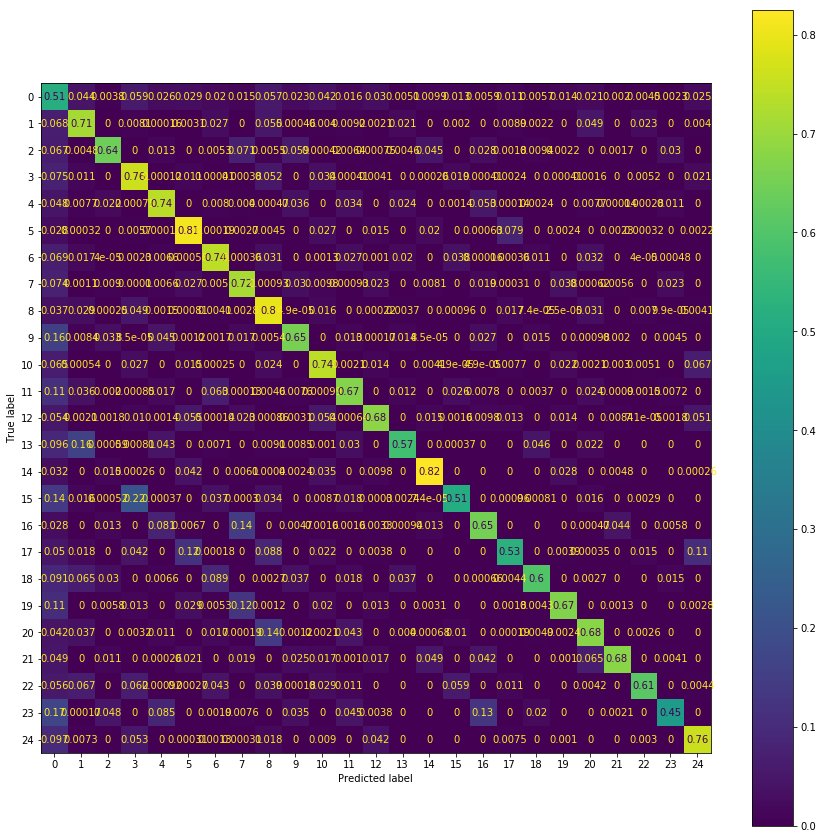

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

cm = confusion_matrix(val_split.labels.astype(int).flatten(), preds.flatten(), normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)

In [13]:
import dataloader

def get_max_ambiguous_class(cm, c_ix): # lazycats??
    pool = np.append(cm[c_ix][:c_ix], cm[c_ix][c_ix+1:])
    score = np.max(pool)
    a_ix = np.argmax(pool)
    if a_ix >= c_ix:
        a_ix += 1
    
    return a_ix, dataloader._MAJMIN_CLASSES[a_ix], score
    
get_max_ambiguous_class(cm, 5)

(17, 'E:min', 0.07862190812720848)

In [14]:
from collections import Counter
def get_ds_counts(ds_labels):
    count_tuples = sorted(Counter(ds_labels.astype(int).flatten()).items(), key=lambda kv: kv[0])
    return [count_tuple[1] for count_tuple in count_tuples]

get_ds_counts(val_split.labels)[:5]

[64526, 37292, 11977, 33985, 21381]

In [15]:
trn_cm = confusion_matrix(train_split.labels.astype(int).flatten(), trn_preds.flatten(), normalize='true')

In [16]:
import pandas as pd

classes = np.unique(val_split.labels).astype(int)
summary_df = pd.DataFrame(columns=['acc', 'amb_ix', 'amb_name', 'amb_pct', 'trn_acc'])

for c_ix in classes:
    acc = cm[c_ix][c_ix]
    a_ix, a_name, a_pct = get_max_ambiguous_class(cm, c_ix)
    trn_acc = trn_cm[c_ix][c_ix]
    
    summary_df.loc[len(summary_df)] = [acc, a_ix, a_name, a_pct, trn_acc]

In [17]:
summary_df['val_cnt'] = get_ds_counts(val_split.labels)
summary_df['val_pct'] = summary_df['val_cnt'] / summary_df['val_cnt'].sum()
summary_df['trn_cnt'] = get_ds_counts(train_split.labels)
summary_df['trn_pct'] = summary_df['trn_cnt'] / summary_df['trn_cnt'].sum()
summary_df['name'] = dataloader._MAJMIN_CLASSES

In [19]:
# val acc, max ambiguity+pct,trn acc, val count+pct, trn count+pct
summary_df = summary_df[['name','acc','amb_ix','amb_name','amb_pct',
                         'trn_cnt','trn_pct','val_cnt','val_pct','trn_acc']]

summary_df[summary_df['acc'] > 0.75]

,name,acc,amb_ix,amb_name,amb_pct,trn_cnt,trn_pct,val_cnt,val_pct,trn_acc
3,D:maj,0.761248,0,N,0.074857,241035,0.085845,33985,0.076515,0.864414
5,E:maj,0.810134,17,E:min,0.078622,198252,0.070607,15848,0.035681,0.868450
8,G:maj,0.795321,3,D:maj,0.048889,242984,0.086539,40561,0.091321,0.861300
14,Db:min,0.824578,5,E:maj,0.041843,37794,0.013460,7576,0.017057,0.745727
24,B:min,0.759750,0,N,0.097496,72237,0.025727,9744,0.021938,0.787491


In [20]:
print(summary_df['trn_pct'].mean(), summary_df['val_pct'].mean(), summary_df['amb_pct'].mean())

0.039999999999999994 0.04 0.09718352350508903


In [21]:
summary_df[summary_df['acc'] < 0.75][['name','acc','amb_name','amb_pct','trn_pct','val_pct']].sort_values(by='acc')

,name,acc,amb_name,amb_pct,trn_pct,val_pct
23,Bb:min,0.452471,N,0.172485,0.006403,0.013027
15,D:min,0.510367,D:maj,0.215672,0.030977,0.030514
0,N,0.514707,D:maj,0.059449,0.105492,0.145276
17,E:min,0.531438,E:maj,0.119922,0.030691,0.025495
13,C:min,0.573345,C:maj,0.162232,0.012639,0.030712
18,F:min,0.602081,N,0.090788,0.013082,0.010168
22,A:min,0.613420,C:maj,0.067283,0.033613,0.024595
2,Db:maj,0.643149,Gb:maj,0.071387,0.029932,0.026966
16,Eb:min,0.651773,Gb:maj,0.143571,0.012941,0.014411
9,Ab:maj,0.654712,N,0.157277,0.036248,0.053109


In [28]:
summary_df[summary_df['acc'] < 0.70][non_zero_filt]\
    [['name','acc','amb_name','amb_pct','trn_pct','val_pct']].sort_values(by='acc')

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,name,acc,amb_name,amb_pct,trn_pct,val_pct
23,Bb:min,0.452471,N,0.172485,0.006403,0.013027
15,D:min,0.510367,D:maj,0.215672,0.030977,0.030514
17,E:min,0.531438,E:maj,0.119922,0.030691,0.025495
13,C:min,0.573345,C:maj,0.162232,0.012639,0.030712
18,F:min,0.602081,N,0.090788,0.013082,0.010168
22,A:min,0.613420,C:maj,0.067283,0.033613,0.024595
2,Db:maj,0.643149,Gb:maj,0.071387,0.029932,0.026966
16,Eb:min,0.651773,Gb:maj,0.143571,0.012941,0.014411
9,Ab:maj,0.654712,N,0.157277,0.036248,0.053109
19,Gb:min,0.669421,Gb:maj,0.123967,0.013584,0.013621


##### Thoughts

- The least accurate chord (Bbm) has the least training data. We might gain a lot on data augmentation.
    - we shall limit augmentation on valid chords i.e. exclude no-chord (N)
    - we can pre-augment (larger training data) or augment on-the-fly (transformations)
    - consider weighted augmenting
    - we should try to AVOID augmenting bad data (how?)
- QUICK: try weighted training
- lots of X:min <-> X:maj ambiguity
- major chords generally more accurate

#### Per-song analysis

In [12]:
from sklearn.metrics import accuracy_score
import lazycats.np as catnp
import dataloader

_BATCH_SIZE = 128
_LABEL_TYPE = 'majmin'
_CHROMA_NUM_FEATS = 24

def predict_from_chroma(model, chroma_vectors):
    chordseq_vectors = catnp.divide_to_subsequences(chroma_vectors, sub_len=_SEQ_LEN)
    pred_labels, _, _, _ = model.predict(chordseq_vectors, batch_size=32)
    pred_labels = pred_labels.flatten()
    if len(chroma_vectors) < len(pred_labels): # remove pad
        pad_st = len(pred_labels)-_SEQ_LEN
        pad_ed = pad_st+len(pred_labels)-len(chroma_vectors)
        pred_labels = np.append(pred_labels[:pad_st], pred_labels[pad_ed:])

    assert(len(pred_labels)==len(chroma_vectors))
    return pred_labels

def get_predictions_and_labels(model, song_id):
    chroma_vectors, chord_labels = dataloader.get_chord_features_and_labels(song_id, label_type=_LABEL_TYPE,
                                                                            remove_ambiguous=False)
    assert(chroma_vectors.shape[-1] == _CHROMA_NUM_FEATS)
    pred_labels = predict_from_chroma(model, chroma_vectors)
    assert(len(pred_labels)==len(chord_labels))
    return pred_labels, chord_labels

for _id in test_ids:
    pred_labels, chord_labels = get_predictions_and_labels(model, _id)
    acc = accuracy_score(chord_labels, pred_labels)
    print(f'{_id}: {acc}')
    #break

1289: 0.7667238421955404
736: 0.49593976081500074
637: 0.6563327032136106
270: 0.8167701863354038
18: 0.6729610285255122


In [14]:
df_songs.loc[test_ids]

,title,artist,no_chord_percent
id,,,
1289,There She Goes,The La's,0.034247
736,Do I Do,Stevie Wonder,0.451669
637,Human Nature,Michael Jackson,0.025762
270,In My Room,The Beach Boys,0.051888
18,Kiss On My List,Daryl Hall & John Oates,0.043451


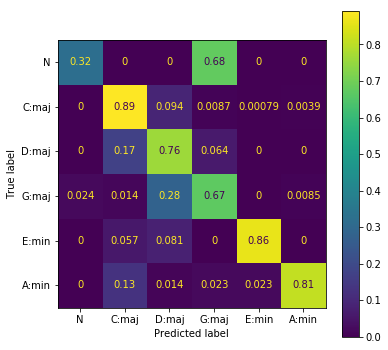

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

cm = confusion_matrix(chord_labels, pred_labels, normalize='true')
chord_classes_index = np.unique([pred_labels, chord_labels])
chord_classes = [dataloader._MAJMIN_CLASSES[ix] for ix in chord_classes_index]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=chord_classes)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)

In [79]:
import pandas as pd

summary_df = pd.DataFrame(columns=['acc', 'amb_ix', 'amb_name', 'amb_pct'])

for c_ix in range(len(cm)):
    acc = cm[c_ix][c_ix]
    ac_ix, _, a_pct = get_max_ambiguous_class(cm, c_ix)
    a_ix = chord_classes_index[ac_ix]
    a_name = chord_classes[ac_ix]
    
    summary_df.loc[len(summary_df)] = [acc, a_ix, a_name, a_pct]

In [84]:
summary_df['song_cnt'] = get_ds_counts(chord_labels)
summary_df['song_pct'] = summary_df['song_cnt'] / summary_df['song_cnt'].sum()
summary_df['name'] = chord_classes
summary_df[['name','acc','amb_name','amb_pct','song_pct']]

,name,acc,amb_name,amb_pct,song_pct
0,N,0.321739,G:maj,0.678261,0.034247
1,C:maj,0.892575,D:maj,0.093997,0.377010
2,D:maj,0.762419,C:maj,0.173866,0.275759
3,G:maj,0.671388,D:maj,0.281870,0.210244
4,E:min,0.861789,D:maj,0.081301,0.036629
5,A:min,0.810811,C:maj,0.130631,0.066111


#### For visual evaluation

In [117]:
# visually compare

def dump_chord_array(labels, fn):
    arr_str = np.array(list(map(lambda ix: dataloader._MAJMIN_CLASSES[ix], labels)))
    arr_str_subseq = catnp.divide_to_subsequences(arr_str, sub_len=_SEQ_LEN, pad='X', pre_pad=False)
    np.savetxt(fn, arr_str_subseq, fmt='%s', newline='\n\n')
    
dump_chord_array(chord_labels, f'data/eval/{_id}_true_labels.txt')
dump_chord_array(pred_labels, f'data/eval/{_id}_pred_labels.txt')

##### Dump LAB with from pre-generated chroma as input

[1289, 736, 637, 270, 18]

In [13]:
import numpy as np
import dataloader
import lazycats.np as catnp
from tqdm import tqdm

# dump LAB files
def generate_mirex_chords(model, chroma_vectors, step_size, filename):
    pred_labels = predict_from_chroma(model, chroma_vectors)

    chord_labels = catnp.squash_consecutive_duplicates(pred_labels)
    chord_lengths = [0] + list(catnp.contiguous_lengths(pred_labels))
    chord_timestamps = np.cumsum(chord_lengths)

    chord_labels = [dataloader._MAJMIN_CLASSES[label] for label in chord_labels]
    out_labels = [f'{step_size*st}\t{step_size*ed}\t{chord_name}'
                  for st, ed, chord_name in zip(chord_timestamps[:-1], chord_timestamps[1:], chord_labels)]

    assert(filename[-4:] == '.lab')
    with open(filename, 'w') as f:
        for line in out_labels:
            f.write("%s\n" % line)
    
    return out_labels

for song_id in tqdm(test_ids):
    step_size, chroma_vectors = dataloader.get_chroma_matrix(song_id, return_step_size=True)
    out_labels = generate_mirex_chords(model, chroma_vectors, step_size,
                                       f'data/eval/{song_id:04d}/chordino_pred.lab')
out_labels[:5]

100%|██████████| 5/5 [00:00<00:00,  5.93it/s]


['0.0\t0.92879818\tG:maj',
 '0.92879818\t3.71519272\tC:maj',
 '3.71519272\t4.876190445\tG:maj',
 '4.876190445\t8.730702892\tC:min',
 '8.730702892\t12.956734611\tF:maj']

In [8]:
# dump lab file for ALL chords
import dataloader
#from importlib import reload
#reload(dataloader)
dataloader._MAJMIN7_CLASSES.sort()
#dataloader._MAJMIN7_CLASSES
out_labels = [f'{i*0.5}\t{(i+1)*0.5}\t{name}'
              for i, name in enumerate(dataloader._MAJMIN7_CLASSES)]

with open('data/eval/all_chords.lab', 'w') as f:
    for line in out_labels:
        f.write("%s\n" % line)

##### Dump LAB file with WAV as input

In [23]:
# dump LAB
import numpy as np
from scipy.signal import resample
import librosa
import vamp
from tqdm import tqdm

_SAMPLE_RATE = 44100
_STEP_SIZE = 2048/_SAMPLE_RATE

def generate_chroma_from_wav(audio_fn, params={'rollon': 1.0}):
    """ Generate chroma from raw audio """
    
    X, fs = librosa.load(audio_fn, sr=None, mono=True)
    if fs != _SAMPLE_RATE:
        X = resample(X, num=int(len(X)*_SAMPLE_RATE/fs))
        
    out = vamp.collect(X, _SAMPLE_RATE, 'nnls-chroma:nnls-chroma',
                       output='bothchroma', parameters=params)
    
    chroma = out['matrix'][1]
    return chroma

for song_id in tqdm(test_ids):
    chroma_vectors = generate_chroma_from_wav(f'data/eval/{song_id:04d}/audio.wav')
    out_labels = generate_mirex_chords(model, chroma_vectors, _STEP_SIZE, f'data/eval/{song_id:04d}/wav_pred.lab')

out_labels[:5]

#### Packaging tests

In [1]:
from shutil import copy
import vamp

_CHROMA_VAMP_LIB = '../src/res/nnls-chroma.so'
_CHROMA_VAMP_KEY = 'nnls-chroma:nnls-chroma'

def setup_chroma_vamp():
    vamp_paths = vamp.vampyhost.get_plugin_path()
    for path in vamp_paths:
        try: 
            if not os.path.exists(os.path.join(path, _CHROMA_VAMP_LIB)):
                os.makedirs(path, exist_ok=True)
                copy(_CHROMA_VAMP_LIB, path)
            vamp.vampyhost.load_plugin(_CHROMA_VAMP_KEY, 44100, vamp.vampyhost.ADAPT_NONE)
            print(f'Using NNLS-Chroma VAMP plugin in {path}')
        except Exception as e:
            continue
    
    print(f'WARNING: NNLS-Chroma VAMP plugin not setup properly. '
          f'Try copying `{_CHROMA_VAMP_LIB}` in any of following directories: {vamp_paths}')

setup_chroma_vamp()

False

In [3]:
vamp.vampyhost.load_plugin(_CHROMA_VAMP_KEY, 44100, vamp.vampyhost.ADAPT_NONE)

In [3]:
vamp_paths = vamp.vampyhost.get_plugin_path()
print(vamp_paths)

['/home/cjbayron/vamp', '/home/cjbayron/.vamp', '/usr/local/lib/vamp', '/usr/lib/vamp']


In [4]:
for path in vamp_paths:
    if os.path.exists(path):
        print(f'{path}: {os.listdir(path)}')

/home/cjbayron/vamp: []
/home/cjbayron/.vamp: ['nnls-chroma.so']
/usr/local/lib/vamp: []


In [ ]:
# import os
# _VAMP_PATH = '../src/res'
# _CHROMA_VAMP_KEY = 'nnls-chroma:nnls-chroma'

# def setup_chroma_vamp():
#     os.environ["VAMP_PATH"] = _VAMP_PATH
#     try: 
#         vamp.vampyhost.load_plugin(_CHROMA_VAMP_KEY, 44100, vamp.vampyhost.ADAPT_NONE)
#         print(f'Using NNLS-Chroma VAMP plugin in {_VAMP_PATH}')
#         return True
#     except Exception as e:
#         print('WARNING: NNLS-Chroma VAMP plugin not setup properly')

# setup_chroma_vamp()

In [21]:
import os
import gdown
from tensorflow import keras

_CHORD_MODEL_URL = 'https://drive.google.com/uc?id=1XBn7FyYjF8Ff6EuC7PjwwPzFBLRXGP7n'
_EXT_RES_DIR = os.path.join(os.path.expanduser('~'), '.autochord')
_CHORD_MODEL_DIR = os.path.join(_EXT_RES_DIR, 'chroma-seq-bilstm-crf-v1')
_CHORD_MODEL = None

def download_model():
    os.makedirs(_EXT_RES_DIR, exist_ok=True)
    model_zip = os.path.join(_EXT_RES_DIR, 'model.zip')
    gdown.download(_CHORD_MODEL_URL, model_zip, quiet=False)

    model_files = gdown.extractall(model_zip)
    model_files.sort()
    os.remove(model_zip)
    print(f'Chord model downloaded in {model_files[0]}')
    
    return model_files[0]

try:
    if not os.path.exists(_CHORD_MODEL_DIR):
        _CHORD_MODEL_DIR = download_model()

    _CHORD_MODEL = keras.models.load_model(_CHORD_MODEL_DIR)
    print(f'Loaded model from {_CHORD_MODEL_DIR}')
except Exception as e:
    raise Exception(f'Error in loading model: {e}')

Downloading...
From: https://drive.google.com/uc?id=1XBn7FyYjF8Ff6EuC7PjwwPzFBLRXGP7n
To: /home/cjbayron/.autochord/model.zip
2.26MB [00:00, 7.55MB/s]


Chord model downloaded in /home/cjbayron/.autochord/chroma-seq-bilstm-crf-v1/
Loaded model from /home/cjbayron/.autochord/chroma-seq-bilstm-crf-v1/


In [7]:
# from google_drive_downloader import GoogleDriveDownloader as gdd

# gdd.download_file_from_google_drive(file_id='1XBn7FyYjF8Ff6EuC7PjwwPzFBLRXGP7n',
#                                     dest_path='./test.zip',
#                                     unzip=True)

#### MIREX eval

In [15]:
len(val_idxs)

100

In [17]:
help(os.makedirs)

Help on function makedirs in module os:

makedirs(name, mode=511, exist_ok=False)
    makedirs(name [, mode=0o777][, exist_ok=False])
    
    Super-mkdir; create a leaf directory and all intermediate ones.  Works like
    mkdir, except that any intermediate path segment (not just the rightmost)
    will be created if it does not exist. If the target directory already
    exists, raise an OSError if exist_ok is False. Otherwise no exception is
    raised.  This is recursive.



In [49]:
# generate labels and dump
from tqdm import tqdm
for song_id in tqdm(val_idxs):
    step_size, chroma_vectors = dataloader.get_chroma_matrix(song_id, return_step_size=True)
    lab_fn = f'data/eval/{song_id:04d}/majmin_pred.lab'
    os.makedirs(os.path.dirname(lab_fn), exist_ok=True)
    out_labels = generate_mirex_chords(model, chroma_vectors, step_size, lab_fn)
    #break

100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


In [50]:
import mir_eval
import numpy as np

def get_song_accuracy(_id):
    ref_lab = f'data/McGill-Billboard/{_id:04d}/majmin.lab'
    est_lab = f'data/eval/{_id:04d}/majmin_pred.lab'
    
    ref_intervals, ref_labels = mir_eval.io.load_labeled_intervals(ref_lab, comment='\n')
    est_intervals, est_labels = mir_eval.io.load_labeled_intervals(est_lab, comment='\n')
    est_intervals, est_labels = mir_eval.util.adjust_intervals(
        est_intervals, est_labels, ref_intervals.min(),
        ref_intervals.max(), mir_eval.chord.NO_CHORD,
        mir_eval.chord.NO_CHORD)
    intervals, ref_labels, est_labels = mir_eval.util.merge_labeled_intervals(
        ref_intervals, ref_labels, est_intervals, est_labels)
    durations = mir_eval.util.intervals_to_durations(intervals)
    
    root_comparisons = mir_eval.chord.root(ref_labels, est_labels)
    root_score = mir_eval.chord.weighted_accuracy(root_comparisons, durations)
    
    majmin_comparisons = mir_eval.chord.majmin(ref_labels, est_labels)
    majmin_score = mir_eval.chord.weighted_accuracy(majmin_comparisons, durations)
    
    return root_score, majmin_score

root_scores, majmin_scores = [], []
for i, _id in tqdm(enumerate(val_idxs)):
    #print(get_song_accuracy(_id))
    #if i == 10:
    #    break
    root_score, majmin_score = get_song_accuracy(_id)
    root_scores.append(root_score)
    majmin_scores.append(majmin_score)
    
print(np.mean(root_scores), np.mean(majmin_scores))

100it [00:00, 170.49it/s]

0.7477238911820636 0.706245610553597


#### Full recognition time

In [20]:
import autochord
import librosa
from tqdm import tqdm
import time

durs = []
inf_durs = []
for _id in tqdm(test_ids):
    audio_fn = f'data/audio/{_id:04d}/audio.wav'
    durs.append(librosa.get_duration(filename=audio_fn))
    
    st = time.time()
    autochord.recognize(audio_fn)
    ed = time.time()
    
    inf_durs.append(ed-st)

100%|██████████| 5/5 [00:43<00:00,  8.67s/it]


In [21]:
rates = []
for dur, inf_dur in zip(durs, inf_durs):
    inf_rate = inf_dur/dur
    
    print(inf_rate)
    rates.append(inf_rate)
    
avg_inf_rate = sum(rates)/len(rates)
print(f'Avg. Inf: {avg_inf_rate} inf-s/audio-s, for a 4-min. song: {avg_inf_rate*4*60} s')

0.030599389579666184
0.03181957054019855
0.02938385362660789
0.029459688288922297
0.030897207307190783
Avg. Inf: 0.030431941868517144 inf-s/audio-s, for a 4-min. song: 7.303666048444114 s


In [19]:
feat_dur = []
pred_dur = []
for _id, dur in tqdm(zip(test_ids, durs)):
    audio_fn = f'data/audio/{_id:04d}/audio.wav'
    
    st = time.time()
    chroma_vectors = autochord.generate_chroma(audio_fn)
    ed = time.time()
    feat_dur.append((ed-st)/dur)
    
    st = time.time()
    pred_labels = autochord.predict_chord_labels(chroma_vectors)
    ed = time.time()
    pred_dur.append((ed-st)/dur)
    
print('Avg. Feat. extraction (4-min): ', (sum(feat_dur)/len(feat_dur))*4*60 )
print('Avg. Pred. (4-min): ', (sum(pred_dur)/len(pred_dur))*4*60 )

5it [00:40,  8.17s/it]

Avg. Feat. extraction (4-min):  6.732581949222247
Avg. Pred. (4-min):  0.1058613091303086
